## Biochemical Systems Theory and S-System Models

### Introduction

Biochemical Systems Theory (BST) is a mathematical modeling framework for biochemical systems based on ordinary differential equations (ODEs), where biochemical processes are modeled using power-law expansions in the system’s variables. BST has been developed since the 1960s by [Michael Savageau](https://en.wikipedia.org/wiki/Michael_Antonio_Savageau), [Eberhard Voit](https://en.wikipedia.org/wiki/Eberhard_Voit), and others for the analysis of biochemical processes.

One of the main tools of BST is the modeling of the concentration of metabolites in a metabolic network as a dynamic S-system. For example, suppose we want to model a metabolic network that consists of a species set $\mathcal{M}$ and a reaction set $\mathcal{R}$. Then, we can write a concentation balance equation around each member of the species set $\mathcal{M}$ of the form: 

$$\frac{dX_{i}}{dt} = \sum_{r\in\mathcal{R}}\sigma_{i,r}\cdot\theta_{r}\prod_{m\in\mathcal{M}}X_{m}^{\gamma_{r,m}}-\mu{X}_{i}\qquad\forall{i}\in\mathcal{M}$$

where $\sigma_{i,r}$ denotes the stoichiometric coefficient species $i$ in reaction $r$, $X_{m}$ denotes the concentration of species $m$, and $\gamma_{r,m}$ denotes the reaction order of species $m$ in reaction $r$, and $\mu$ denotes the specific growth rate; the last term is dilution due to growth (accounts for dilution when concentrations are written in cell mass specific units). The dilution due to growth term is not present in a cell-free system (unless there is a significant volume change).

### Case study

<img src="./figs/Fig-Linear-Pathway-BST-Example.png" style="margin:auto; width:50%">

Let's build a small S-system model of a linear pathway with end-product feedback inhibition to understand better how these models work (and generally how kinetic simulations work). 

Consider the example pathway above operating in a cell-free system. A three-step pathway catalyzed by enzymes $E_{1}$, $E_{2}$ and $E_{3}$ converts metabolite $X_{1}$ to $X_{4}$. Metabolite $X_{1}$ is produced by some other process at a constant rate, and $X_{4}$ is consumed at some constant rate. Finally, metabolite $X_{4}$ inhibits the activity of enzyme $E_{1}$.

#### Setup case study environment

In [1]:
import Pkg; Pkg.activate("."); Pkg.resolve(); Pkg.instantiate();

  Activating project at `~/Desktop/julia_work/BST-Model-Case-Study`
  No Changes to `~/Desktop/julia_work/BST-Model-Case-Study/Project.toml`
  No Changes to `~/Desktop/julia_work/BST-Model-Case-Study/Manifest.toml`


In [2]:
using DifferentialEquations
using Plots

In [3]:
include("Example-Code-Library.jl");

#### a) Build the model object from the model file
The [BST model file](./models/Feedback.bst) holds information to build the model equations; however, it does not contain any information about parameter values. We build the model file using the `build` method:

* The function `build(path::String) --> Dict{String,Any}` takes a string holding the `path` to the model file and returns a model `dictionary` holding the components of the model. 

In [4]:
model_dictionary = build(joinpath(_PATH_TO_MODELS, "Feedback.bst"));

In [5]:
model_dictionary

Dict{String, Any} with 9 entries:
  "S"                        => [-1.0 0.0 0.0; 1.0 -1.0 0.0; 0.0 1.0 -1.0; 0.0 …
  "list_of_static_fators"    => ["E1", "E2", "E3"]
  "list_of_dynamic_species"  => ["X1", "X2", "X3", "X4"]
  "number_of_dynamic_states" => 4
  "static_factors_array"     => [0.0, 0.0, 0.0]
  "number_of_static_states"  => 3
  "total_species_list"       => ["X1", "X2", "X3", "X4", "E1", "E2", "E3"]
  "G"                        => [1.0 0.0 0.0; 0.0 1.0 0.0; … ; 0.0 1.0 0.0; 0.0…
  "α"                        => [1.0, 1.0, 1.0]

In [6]:
model_dictionary["list_of_dynamic_species"]

4-element Vector{String}:
 "X1"
 "X2"
 "X3"
 "X4"

In [7]:
G = model_dictionary["G"]

7×3 Matrix{Float64}:
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0
 1.0  0.0  0.0
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0

In [56]:
G[4,1] = 0.0;

In [9]:
icv = [10.0, 0.1, 0.1, 1.1];
model_dictionary["initial_condition_vector"] = icv;

In [10]:
model_dictionary["G"]

7×3 Matrix{Float64}:
  1.0  0.0  0.0
  0.0  1.0  0.0
  0.0  0.0  1.0
 -2.0  0.0  0.0
  1.0  0.0  0.0
  0.0  1.0  0.0
  0.0  0.0  1.0

In [11]:
model_dictionary["total_species_list"]

7-element Vector{String}:
 "X1"
 "X2"
 "X3"
 "X4"
 "E1"
 "E2"
 "E3"

In [12]:
model_dictionary["S"]

4×3 Matrix{Float64}:
 -1.0   0.0   0.0
  1.0  -1.0   0.0
  0.0   1.0  -1.0
  0.0   0.0   1.0

In [18]:
model_dictionary["α"] = [10.0, 10.0, 10.0];

In [14]:
model_dictionary["static_factors_array"] = [0.1, 0.1, 0.1];

#### b) Set test values for the model parameters in the $G$-matrix and $\alpha$-vector

In [57]:
(T, X, Z) = evaluate(model_dictionary; tspan=(0.0,16.0), Δt = 0.01);

In [23]:
X

401×4 Matrix{Float64}:
 10.0      0.1       0.1       1.1
  9.91777  0.180824  0.100404  1.101
  9.83637  0.260024  0.1016    1.10201
  9.75578  0.337623  0.103565  1.10304
  9.676    0.413645  0.106274  1.10408
  9.59702  0.48811   0.109705  1.10516
  9.51885  0.561039  0.113834  1.10628
  9.44147  0.63245   0.118641  1.10744
  9.36488  0.702362  0.124103  1.10866
  9.28908  0.770792  0.130199  1.10993
  9.21407  0.837756  0.136908  1.11126
  9.13985  0.90327   0.144209  1.11267
  9.06642  0.967347  0.152083  1.11415
  ⋮                            
  4.29232  0.35468   0.772475  5.88052
  4.29108  0.352384  0.768307  5.88823
  4.28985  0.350108  0.764157  5.89589
  4.28861  0.34785   0.760026  5.90351
  4.28738  0.345612  0.755913  5.91109
  4.28616  0.343392  0.751819  5.91863
  4.28494  0.341191  0.747744  5.92613
  4.28372  0.339008  0.743688  5.93358
  4.2825   0.336844  0.739651  5.941
  4.28129  0.334698  0.735632  5.94838
  4.28008  0.33257   0.731632  5.95571
  4.27888  0.3304

In [17]:
1/(2.1)^2

0.22675736961451246

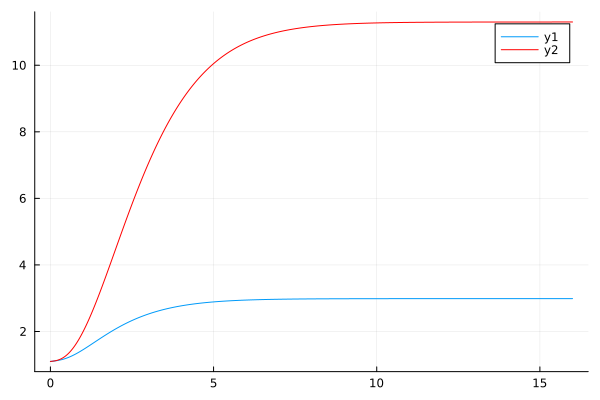

In [58]:
plot!(T,X[:,4], c=:red)

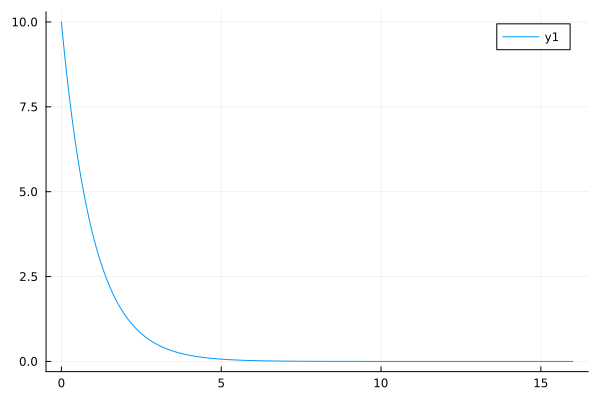

In [59]:
plot(T,X[:,1])